# 2 - Game Traffic Generator - CUSTOM-MADE GAME

This notebook provides a step-by-step solution to generate simplified gaming network traffic, based on captured packets.

Here, we are doing the exact same steps as in the valorant notebook, but extending the notebook in the 5th part, where we are communicating with a real game server.

The steps in this notebook will be less descriptive, as we've already seen the process in the previous one

## 1 - Capturing Packets

---
## 2 - Analyzing Packets

### 2.1 Getting the data

Access the captured packets generated by wireshark, and create a pandas dataframe with information about their inter-departure-time (IDT) and size.

In [1]:
#
# Imports
#
import os
import time
import dpkt
import random
import socket
import datetime
import threading  
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import deepcopy
from collections import deque

In [2]:
#
# Global Jupyter Configurations
#

# set matplotlib's backend to inline
%matplotlib inline

# set maximum amount of display rows
pd.set_option('display.max_rows', 500)

In [3]:
def get_pcap_info(pcap):
    """Generates a pd.DataFrame with the packets, their IDT and size"""
    
    # sets auxiliar time for generating IDT
    previous_time = 0
    
    # list of packets with their info
    rows = []
    
    # iterate through every packet
    for (ts, buf) in pcap:
        
        # if it's the first packet, we don't have it's IDT
        if(previous_time == 0):
            previous_time = ts
            continue
            
        # get the packet protocol
        loo = dpkt.loopback.Loopback(buf)
        protocol = repr(loo.data.data)[:3]
        
        # get the packet data
        data = loo.data.data.data
        
        # get the idt
        idt = int((ts-previous_time)*1000)
        
        # get the size
        size = len(buf)

        # create a new row with the packet information
        rows.append([protocol, data, idt, size])
        
        # update previous_time
        previous_time = ts
    
    # return created dataframe
    return pd.DataFrame(rows, columns=["PROTOCOL", "DATA", "IDT", "SIZE"])

In [4]:
# open a packet capture file for reading
f = open('./FPSGAME_client.pcap', 'rb')
pcap = dpkt.pcap.Reader(f)

# generate a dataframe with the packet information
info = get_pcap_info(pcap)
info

,PROTOCOL,DATA,IDT,SIZE
0,UDP,b'\x01\x00\x00\x00\x1d\x00\x00\x00\x02\x00\x00...,0,69
1,UDP,b'\x01\x00\x00\x00\x14\x00\x00\x00\x03\x00\x00...,32,60
2,UDP,b'\x01\x00\x00\x00\x1d\x00\x00\x00\x02\x00\x00...,0,69
3,UDP,b'\x01\x00\x00\x00\x14\x00\x00\x00\x03\x00\x00...,32,60
4,UDP,b'\x01\x00\x00\x00\x1d\x00\x00\x00\x02\x00\x00...,0,69
...,...,...,...,...
7998,UDP,b'\x01\x00\x00\x00\x1d\x00\x00\x00\x02\x00\x00...,0,69
7999,UDP,"b""\x01\x00\x00\x00\x14\x00\x00\x00\x03\x00\x00...",33,60
8000,UDP,b'\x01\x00\x00\x00\x1d\x00\x00\x00\x02\x00\x00...,0,69
8001,UDP,b'\x01\x00\x00\x00\x14\x00\x00\x00\x03\x00\x00...,132,60


### 2.2 Checking for possible IDT, SIZE correlation

Visually check for any linear correlation between IDT and SIZE.

<AxesSubplot:xlabel='SIZE'>

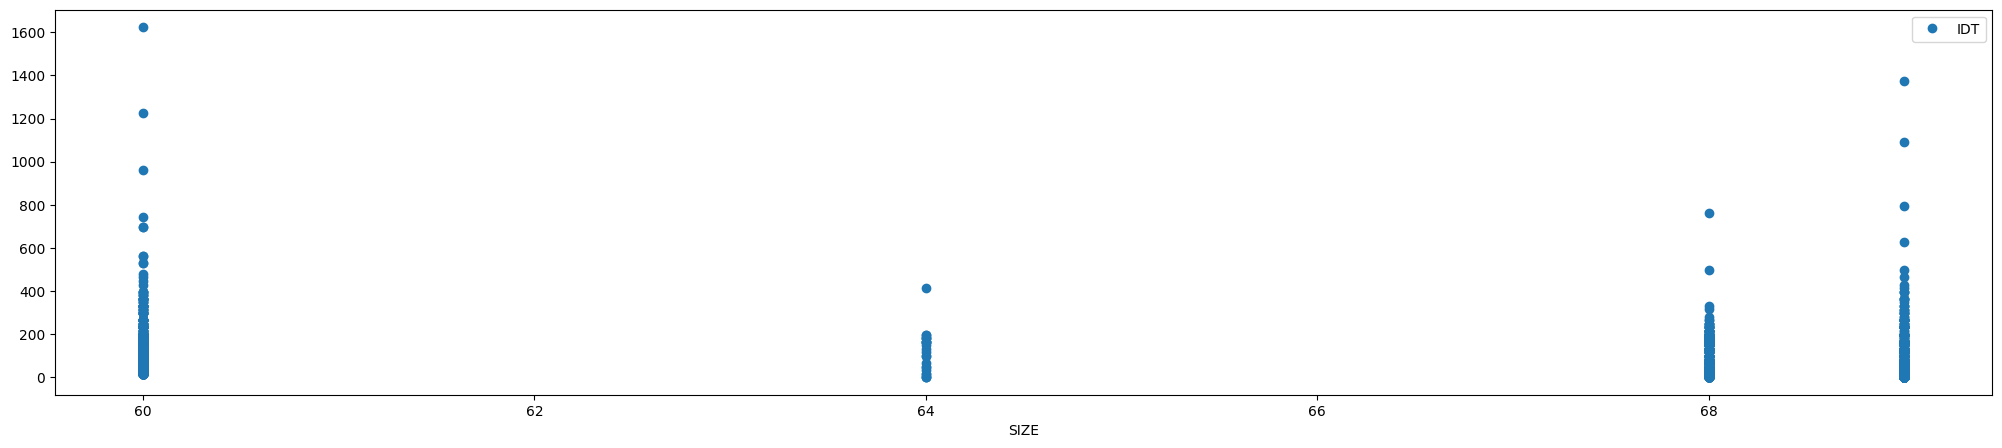

In [5]:
correlation = info
correlation.plot(x='SIZE', y='IDT', style='o', figsize=(25,5))

Based on the graph, it seems IDT and SIZE are significantly independent.

### 2.3 Analysing the data based on size

Create a probability distributed function (PDF), so we can see the frequency of each packet size.

In [6]:
pdf = info.groupby("SIZE").count()
pdf.drop(['PROTOCOL', 'DATA'],inplace=True, axis=1)
pdf.columns = ['Count']
pdf["%"] = 100 * pdf["Count"] / len(info)

Let's plot PDF

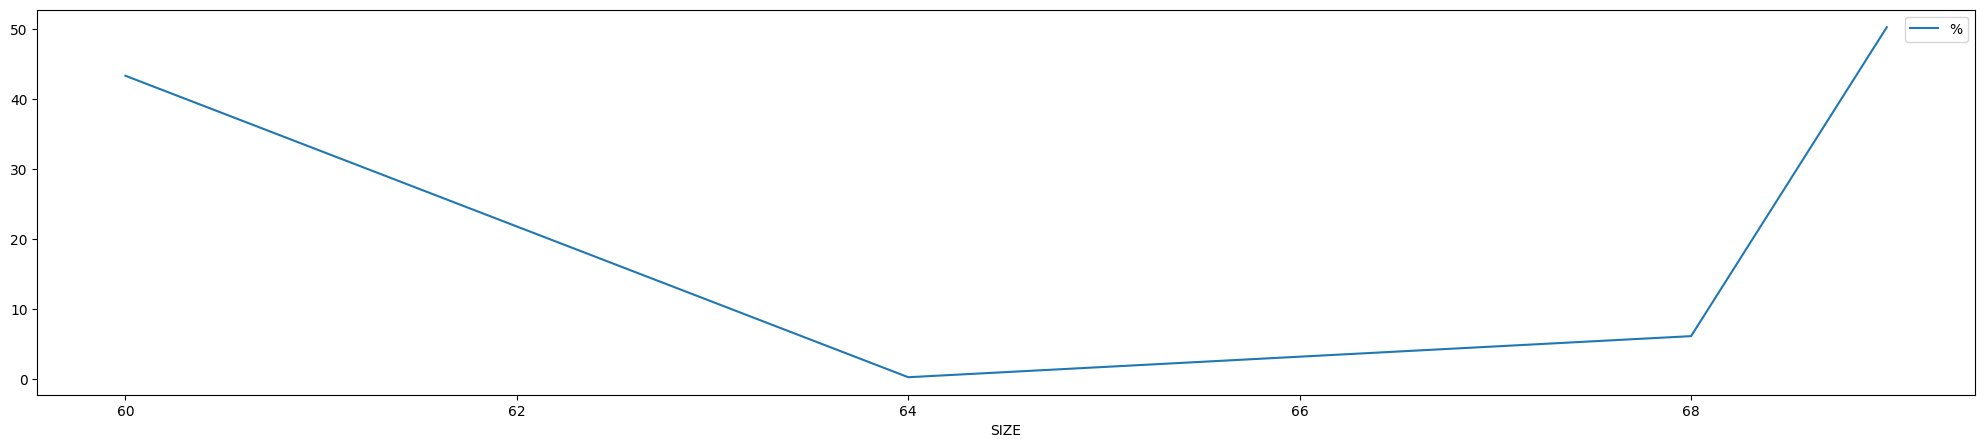

In [7]:
plt.figure(figsize=(25,5))

ax = pdf['%'].plot(label='%')
ax.legend(loc=1)

plt.show()

Apply a wightened moving average to extract the most impactfull dataset points.

In [8]:
# make a usefull copy of PDF
pdf_copy = deepcopy(pdf)

# add dummy rows to pdf_copy start not to lose any data on the WMA
for i in range(pdf_copy.index.min() - 5, pdf_copy.index.min()):
    pdf_copy.loc[i] = [0, 0]

# add dummy rows to pdf_copy end not to lose any data on the WMA
for i in range(pdf_copy.index.max() + 1, pdf_copy.index.max() + 6):
    pdf_copy.loc[i] = [0, 0]

# sort the indexes again
pdf_copy.sort_index(inplace=True)

In [9]:
# define the weights
weights = np.array([1,2,3,4,5,6,5,4,3,2,1])

# aply the weighted moving average
WMA_raw = pdf_copy['%'].rolling(11, center=True).apply(lambda percents: np.dot(percents, weights)/weights.sum(), raw=True)

# convert series to dataframe
WMA = WMA_raw.to_frame()

Let's plot PDF in comparison with WMA

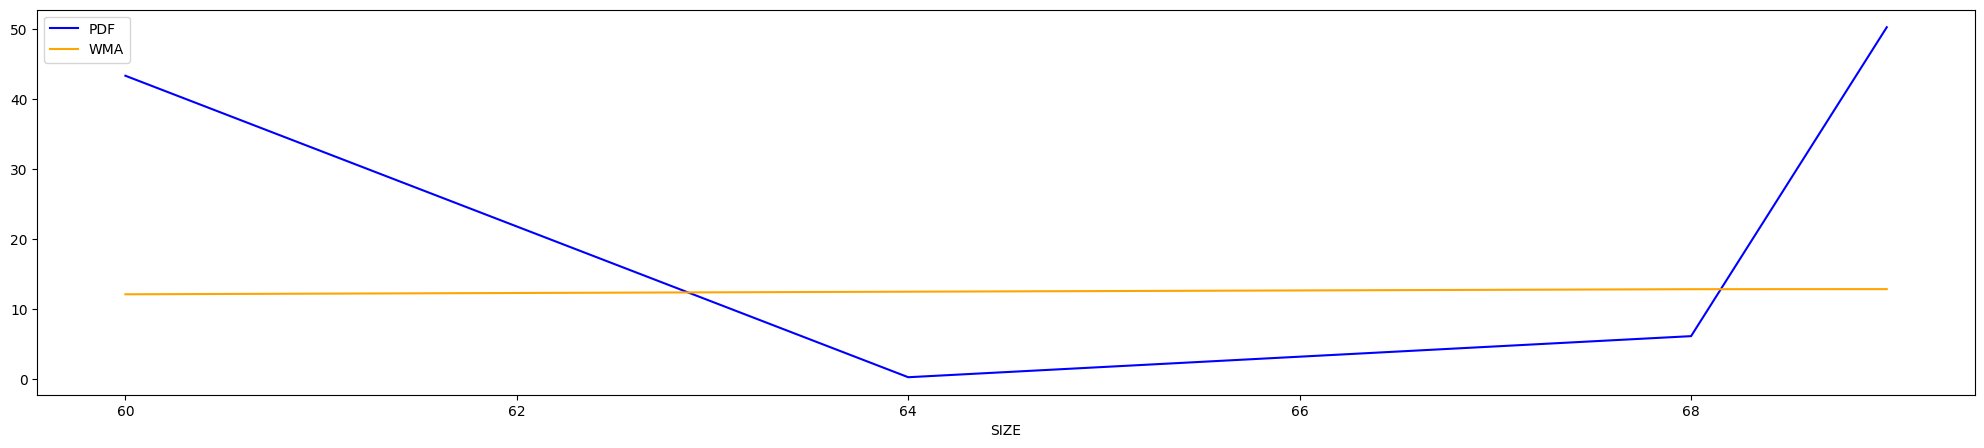

In [10]:
plt.figure(figsize=(25,5))

ax1 = pdf['%'].plot(color='blue', label='PDF')
ax2 = WMA_raw.plot.line(color='orange',  label='WMA')

ax1.legend(loc=1)
ax2.legend(loc=2)

plt.show()

To populate the major dataset, we can append the PDF bigger than WMA, and do as many iteractions as we wish, depending on how simplified we want the major dataset to be.

In [11]:
# define the number of iterations of fetching relevant PDF points
N_ITER = 3

# define the major and minor datasets
major_dataset = pd.DataFrame()
minor_dataset = pd.DataFrame()

# make a usefull copy of PDF
pdf_copy = deepcopy(pdf)

# add dummy rows to pdf_copy start not to lose any data on the WMA
for i in range(pdf_copy.index.min() - 5, pdf_copy.index.min()):
    pdf_copy.loc[i] = [0, 0]

# add dummy rows to pdf_copy end not to lose any data on the WMA
for i in range(pdf_copy.index.max() + 1, pdf_copy.index.max() + 6):
    pdf_copy.loc[i] = [0, 0]

# sort the indexes again
pdf_copy.sort_index(inplace=True)

for i in range(N_ITER):
    
    # aply the weighted moving average
    WMA_raw = pdf_copy['%'].rolling(11, center=True).apply(lambda percents: np.dot(percents, weights)/weights.sum(), raw=True)
    
    # convert series to dataframe
    WMA = WMA_raw.to_frame()

    # get PDF indexes above and below WMA
    major_indexes = np.where(pdf_copy['%'] >= WMA['%'], pdf_copy['%'].index, None)
    minor_indexes = np.where(pdf_copy['%'] >= WMA['%'], None, pdf_copy['%'].index)

    # drop N/A indexes
    major_indexes = major_indexes[major_indexes != np.array(None)]
    minor_indexes = minor_indexes[minor_indexes != np.array(None)]
    
    # if first iteration
    if i == 0:
        
        # major dataset is pdf_copy without minor indexes
        major_dataset = pdf_copy.drop(minor_indexes)
        
    # not first iteration
    else:
        
        # concat current major dataset with pdf_copy without minor indexes
        frames = [major_dataset, pdf_copy.drop(minor_indexes)]
        result = pd.concat(frames)
        
        # sort major dataset
        major_dataset = result.sort_index()
        
    # minor dataset is pdf_copy without major indexes
    minor_dataset = pdf_copy.drop(major_indexes)
    
    # update pdf_copy to continue iterations using minor dataset
    pdf_copy = minor_dataset

Let's plot the major dataset to see PDF's most relevant points

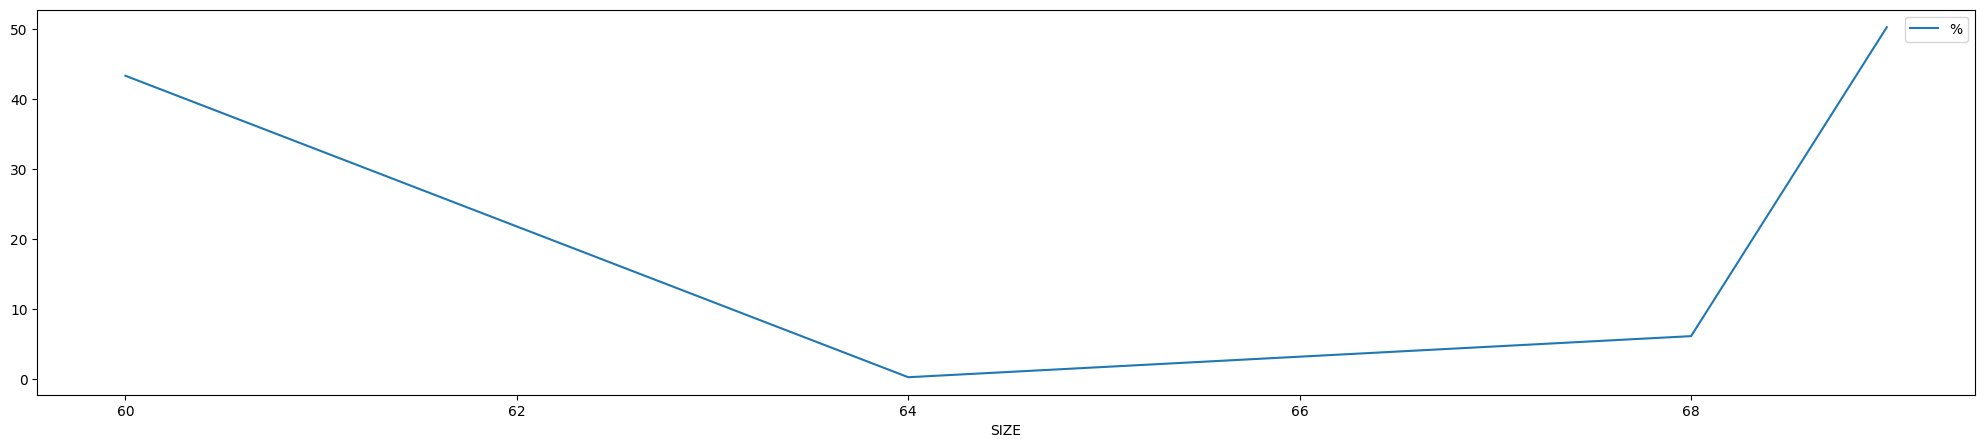

In [12]:
# create plot figure
plt.figure(figsize=(25,5))

# define the plot
ax1 = major_dataset['%'].plot()

# set legends
ax1.legend(loc=1)


# show plot
plt.show()

Visualizing it as a pie chart

In [13]:
pie_major_index = np.where(major_dataset['%'] >= 2.5, major_dataset.index, None)
pie_minor_index = np.where(major_dataset['%'] >= 2.5, None, major_dataset.index)

pie_major_index = pie_major_index[pie_major_index != np.array(None)]
pie_minor_index = pie_minor_index[pie_minor_index != np.array(None)]

pie_major = major_dataset.drop(pie_minor_index)
pie_major.drop(['Count'],inplace=True, axis=1)

pie_minor_sum = major_dataset.drop(pie_major_index)['%'].sum()
pie_major.loc['others'] = pie_minor_sum

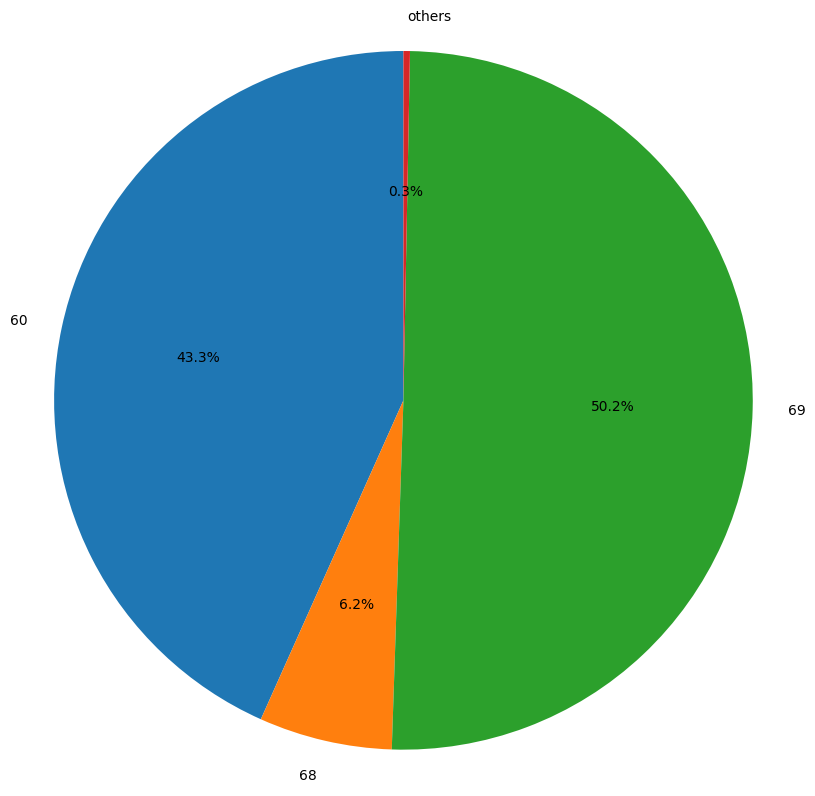

In [14]:
# define the labels
labels = pie_major.index.to_list()

# define the sizes
sizes = pie_major['%'].to_list()

# plot the pie chart
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(sizes, labels=labels, startangle=90, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [15]:
size = deepcopy(major_dataset)

### 2.4 Analyzing the data based on IDT

Create a probability distributed function (PDF), so we can see the frequency of each packet inter-departure-time.

In [16]:
info

,PROTOCOL,DATA,IDT,SIZE
0,UDP,b'\x01\x00\x00\x00\x1d\x00\x00\x00\x02\x00\x00...,0,69
1,UDP,b'\x01\x00\x00\x00\x14\x00\x00\x00\x03\x00\x00...,32,60
2,UDP,b'\x01\x00\x00\x00\x1d\x00\x00\x00\x02\x00\x00...,0,69
3,UDP,b'\x01\x00\x00\x00\x14\x00\x00\x00\x03\x00\x00...,32,60
4,UDP,b'\x01\x00\x00\x00\x1d\x00\x00\x00\x02\x00\x00...,0,69
...,...,...,...,...
7998,UDP,b'\x01\x00\x00\x00\x1d\x00\x00\x00\x02\x00\x00...,0,69
7999,UDP,"b""\x01\x00\x00\x00\x14\x00\x00\x00\x03\x00\x00...",33,60
8000,UDP,b'\x01\x00\x00\x00\x1d\x00\x00\x00\x02\x00\x00...,0,69
8001,UDP,b'\x01\x00\x00\x00\x14\x00\x00\x00\x03\x00\x00...,132,60


In [17]:
pdf = info.groupby("IDT").count()
pdf.drop(['PROTOCOL', 'DATA'],inplace=True, axis=1)
pdf.columns = ['Count']
pdf["%"] = 100 * pdf["Count"] / len(info)

Let's plot PDF

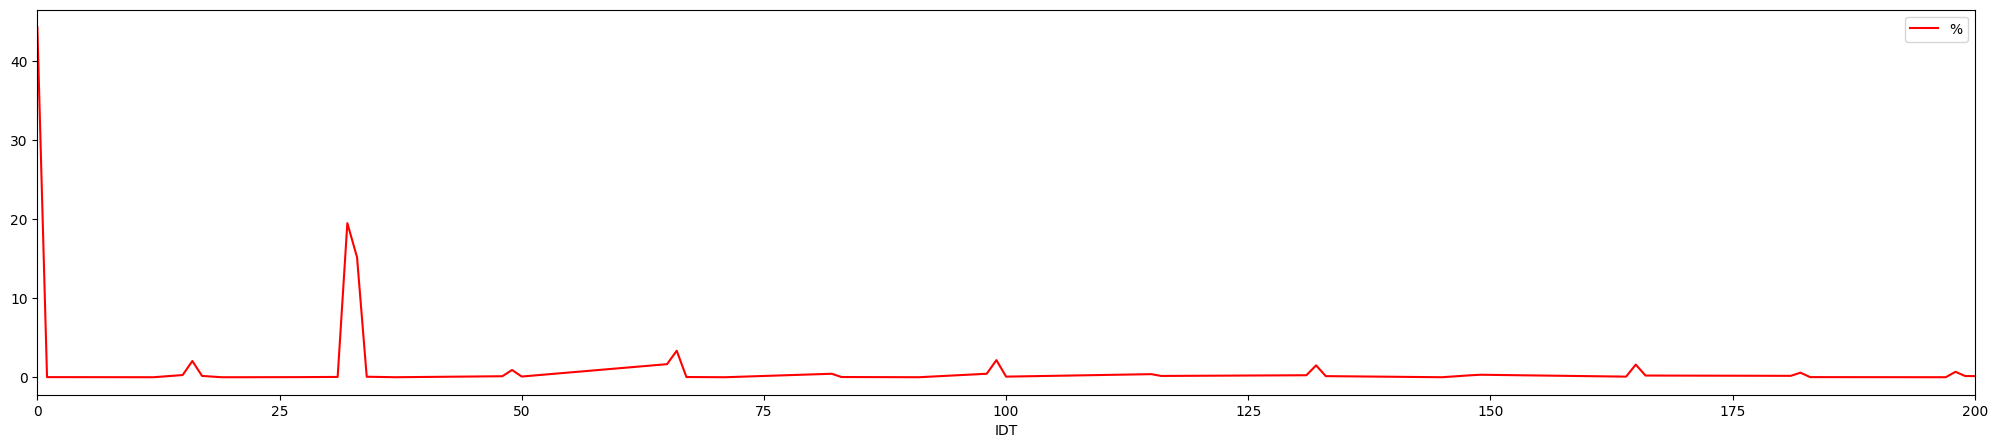

In [18]:
plt.figure(figsize=(25,5))

ax = pdf['%'].plot(label='%', color='r')
ax.legend(loc=1)
ax.set_xlim(0, 200)

plt.show()

Apply a wightened moving average to extract the most impactfull dataset points.

In [19]:
# make a usefull copy of PDF
pdf_copy = deepcopy(pdf)

# add dummy rows to pdf_copy start not to lose any data on the WMA
for i in range(pdf_copy.index.min() - 5, pdf_copy.index.min()):
    pdf_copy.loc[i] = [0, 0]

# add dummy rows to pdf_copy end not to lose any data on the WMA
for i in range(pdf_copy.index.max() + 1, pdf_copy.index.max() + 6):
    pdf_copy.loc[i] = [0, 0]

# sort the indexes again
pdf_copy.sort_index(inplace=True)

In [20]:
# define the weights
weights = np.array([1,2,3,4,5,6,5,4,3,2,1])

# aply the weighted moving average
WMA_raw = pdf_copy['%'].rolling(11, center=True).apply(lambda percents: np.dot(percents, weights)/weights.sum(), raw=True)

# convert series to dataframe
WMA = WMA_raw.to_frame()

Let's plot PDF in comparison with WMA

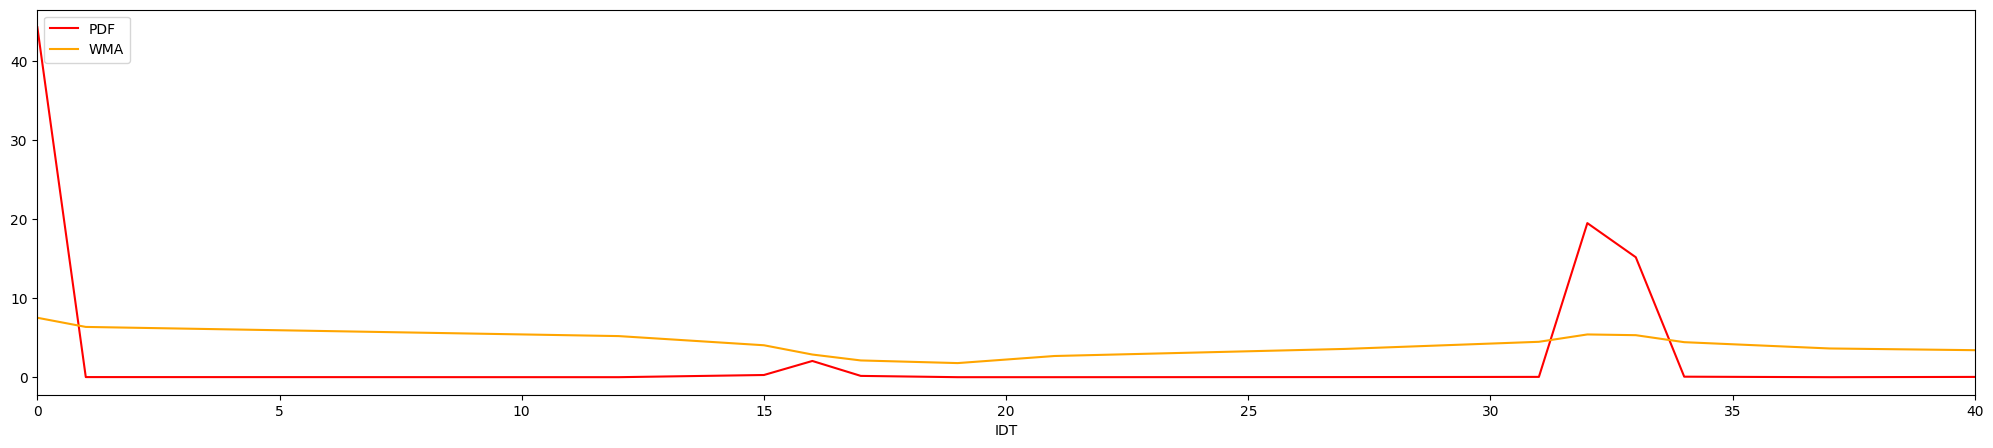

In [21]:
plt.figure(figsize=(25,5))

ax1 = pdf['%'].plot(color='red', label='PDF')
ax2 = WMA_raw.plot.line(color='orange',  label='WMA')

ax1.legend(loc=1)
ax2.legend(loc=2)

ax1.set_xlim(0, 40)
ax2.set_xlim(0, 40)

plt.show()

To populate the major dataset, we can append the PDF bigger than WMA, and do as many iteractions as we wish, depending on how simplified we want the major dataset to be.

In [22]:
# define the number of iterations of fetching relevant PDF points
N_ITER = 2

# define the major and minor datasets
major_dataset = pd.DataFrame()
minor_dataset = pd.DataFrame()

# make a usefull copy of PDF
pdf_copy = deepcopy(pdf)

# add dummy rows to pdf_copy start not to lose any data on the WMA
for i in range(pdf_copy.index.min() - 5, pdf_copy.index.min()):
    pdf_copy.loc[i] = [0, 0]

# add dummy rows to pdf_copy end not to lose any data on the WMA
for i in range(pdf_copy.index.max() + 1, pdf_copy.index.max() + 6):
    pdf_copy.loc[i] = [0, 0]

# sort the indexes again
pdf_copy.sort_index(inplace=True)

for i in range(N_ITER):
    
    # aply the weighted moving average
    WMA_raw = pdf_copy['%'].rolling(11, center=True).apply(lambda percents: np.dot(percents, weights)/weights.sum(), raw=True)
    
    # convert series to dataframe
    WMA = WMA_raw.to_frame()

    # get PDF indexes above and below WMA
    major_indexes = np.where(pdf_copy['%'] >= WMA['%'], pdf_copy['%'].index, None)
    minor_indexes = np.where(pdf_copy['%'] >= WMA['%'], None, pdf_copy['%'].index)

    # drop N/A indexes
    major_indexes = major_indexes[major_indexes != np.array(None)]
    minor_indexes = minor_indexes[minor_indexes != np.array(None)]
    
    # if first iteration
    if i == 0:
        
        # major dataset is pdf_copy without minor indexes
        major_dataset = pdf_copy.drop(minor_indexes)
        
    # not first iteration
    else:
        
        # concat current major dataset with pdf_copy without minor indexes
        frames = [major_dataset, pdf_copy.drop(minor_indexes)]
        result = pd.concat(frames)
        
        # sort major dataset
        major_dataset = result.sort_index()
        
    # minor dataset is pdf_copy without major indexes
    minor_dataset = pdf_copy.drop(major_indexes)
    
    # update pdf_copy to continue iterations using minor dataset
    pdf_copy = minor_dataset

Let's plot the major dataset to see PDF's most relevant points

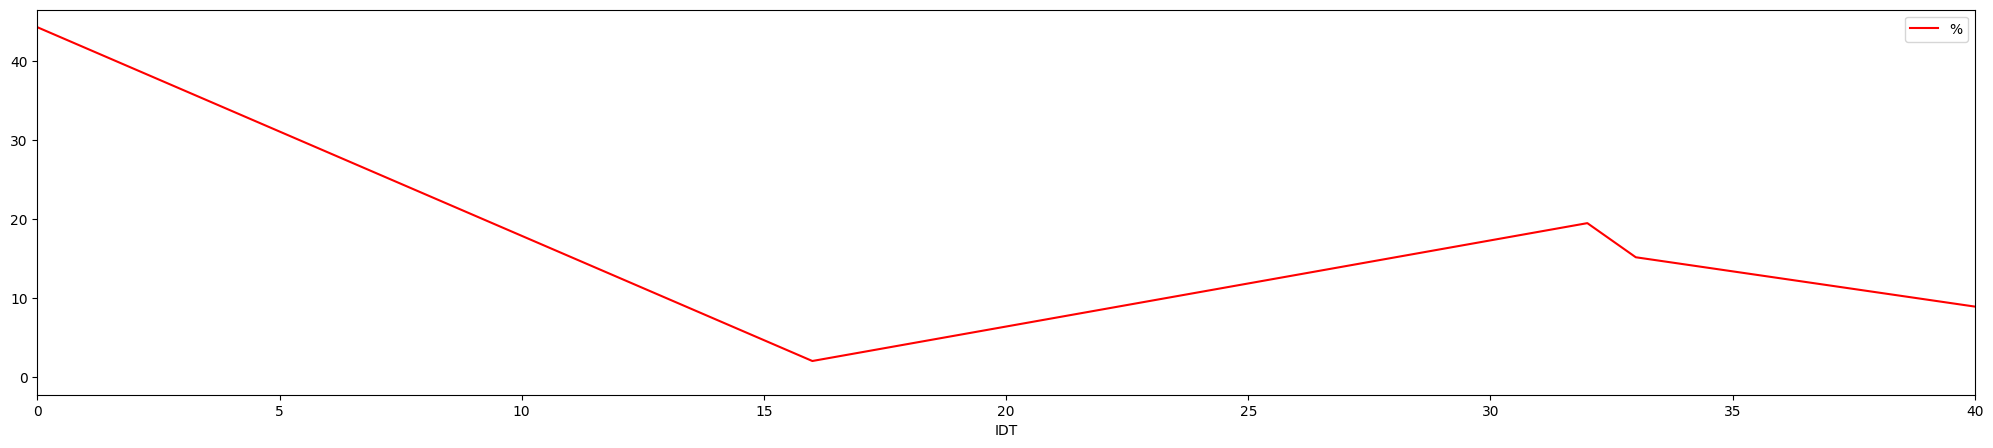

In [23]:
# create plot figure
plt.figure(figsize=(25,5))

# define the plot
ax1 = major_dataset['%'].plot(color='r')

# set legends
ax1.legend(loc=1)

# set limits for better visual
ax1.set_xlim(0, 40)

# show plot
plt.show()

Visualizing it as a pie chart

In [24]:
pie_major_index = np.where(major_dataset['%'] >= 2.5, major_dataset.index, None)
pie_minor_index = np.where(major_dataset['%'] >= 2.5, None, major_dataset.index)

pie_major_index = pie_major_index[pie_major_index != np.array(None)]
pie_minor_index = pie_minor_index[pie_minor_index != np.array(None)]

pie_major = major_dataset.drop(pie_minor_index)
pie_major.drop(['Count'],inplace=True, axis=1)

pie_minor_sum = major_dataset.drop(pie_major_index)['%'].sum()
pie_major.loc['others'] = pie_minor_sum

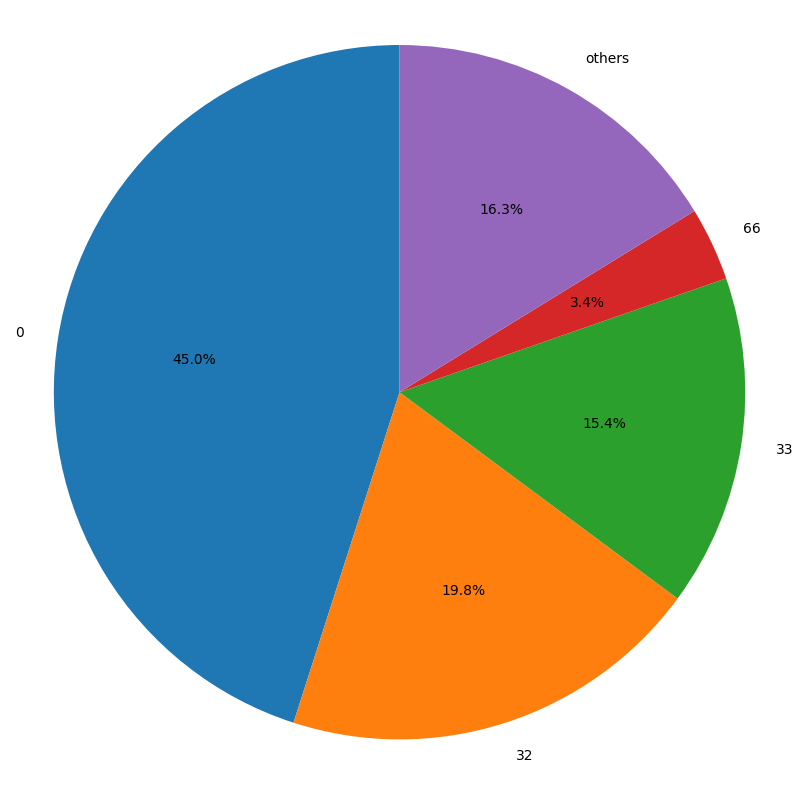

In [25]:
# define the labels
labels = pie_major.index.to_list()

# define the sizes
sizes = pie_major['%'].to_list()

# plot the pie chart
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(sizes, labels=labels, startangle=90, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [26]:
idt = deepcopy(major_dataset)

## 3 - Generating Traffic

Based on the major datasets for IDT and SIZE, we'll be generating random (IDT, Packet) pairs, and populating a double buffered queue. This will be consumed by another thread, sending the packet between IDT time intervals.

In [27]:
# create a mapping from protocol and size, to all possible data in the packet
data_map = info.groupby(['PROTOCOL', 'SIZE'])['DATA'].unique().to_frame().reset_index()
data_map

,PROTOCOL,SIZE,DATA
0,TCP,64,[b'\x10\x00\x00\x00\x06\x00\x00\x00\xc3%a\xbf\...
1,TCP,68,"[b'\x14\x00\x00\x00\x05\x00\x00\x00?\xd3,<\xf0..."
2,UDP,60,[b'\x01\x00\x00\x00\x14\x00\x00\x00\x03\x00\x0...
3,UDP,69,[b'\x01\x00\x00\x00\x1d\x00\x00\x00\x02\x00\x0...


In [28]:
# create a Count cumulative row for size
size['CountCumulative'] = size['Count'].cumsum()

In [29]:
# create a Count cumulative row for idt
idt['CountCumulative'] = idt['Count'].cumsum()

In [30]:
def get_rand_index(df, df_max_point):
    """ Return an index based on probability of cumulative count """
    j = random.randrange(1, df_max_point)
    
    for index, row in df.iterrows():
        if j <= row['CountCumulative']:
            return index

### 3.1 Initializing generator

In [31]:
# define max size of each buffer
MAX_LEN = 100

# define two deques to work as producer and consumer buffers
queues = {"write": deque(maxlen=MAX_LEN), "read": deque(maxlen=MAX_LEN)}

# define an output dataframe to compare generated traffic with original
generated_traffic = pd.DataFrame(columns = ['IDT', 'SIZE'])

In [32]:
def swap_queues(queues):
    """ Swap write and read queues """
    queues['write'], queues['read'] = queues['read'], queues['write']

### 3.1 Producer Thread

In [33]:
def generator(queues):
    """ I run on a thread, generating (idt, packet) tuples and populating a queue """
    
    print("Generator started!")
    
    # count total number of points in each dataset
    idt_points = idt["Count"].sum()
    size_points = size["Count"].sum()
    
    # keep generator running while generating_traffic
    while generating_traffic:
        
        # wait until write queue is empty
        if len(queues['write']) != 0:
            continue
        
        # populate the whole queue
        while len(queues['write']) != MAX_LEN:
        
            # generate IDT and packet
            _idt = get_rand_index(idt, idt_points)
            _size = get_rand_index(size, size_points)
            
            # get protocol from size
            # (this only works for this game as no UDP or TCP have the same size)
            _protocol = data_map.loc[data_map['SIZE'] == _size].iloc[0]['PROTOCOL']
            
            # get data from size
            # (this only works for this game as no UDP or TCP have the same size)
            _data = random.choice(data_map.loc[data_map['SIZE'] == _size].iloc[0]['DATA'])
            
            # enqueue info about the packet
            queues['write'].append({'idt': _idt,
                                    'size': _size,
                                    'protocol': _protocol,
                                    'data': _data})
            
    print("Generator shutting down!\n", end='')

### 3.2 Consumer Thread

In [34]:
def transmitter(queues):
    """ I run on a thread, consuming a queue to transmit a packet in idt intervals """
    
    print("Transmitter started!")
    
    # keep transmitter running while generating_traffic
    while generating_traffic:
        
        # read queue is not empty
        if len(queues["read"]) != 0:
            
            # get packet info from queue
            packet = queues["read"].pop()
            
            # tranmit packet in idt time
            transmit_in_time(packet)
        
        # read queue empty: swap queues
        else:
            swap_queues(queues)
            
    print("Transmitter shutting down!")

In [35]:
def transmit_in_time(packet):
    """ Wait for idt time in miliseconds to transmit a packet """
    # use global output dataframe
    global generated_traffic
    
    # set target time
    t = datetime.datetime.now() + datetime.timedelta(milliseconds=packet['idt'])
    
    # wait for target time
    while t > datetime.datetime.now():
        continue
    
    # transmit package
    frames = [generated_traffic, pd.DataFrame.from_records([{'IDT': packet['idt'], 'SIZE': packet['size']}])]
    generated_traffic = pd.concat(frames)
    
    return

### 3.3 Running the packet generator

In [36]:
# create threads for producer and consumer
p = threading.Thread(name='producer', target=generator, args=[queues])
c = threading.Thread(name='consumer', target=transmitter, args=[queues])

# start the generator
generating_traffic = True

# start the producer
p.start()

# wait a second for producer to fill first queue
time.sleep(1)

# start consumer
c.start()

# run the packet generator for 10 seconds and then shut down
time.sleep(10)
generating_traffic = False

Generator started!
Transmitter started!
Transmitter shutting down!Generator shutting down!



## 4 - Analyzing generated traffic

In [37]:
generated_traffic

,IDT,SIZE
0,0,69
0,0,69
0,33,68
0,0,60
0,33,69
0,0,69
0,32,69
0,0,69
0,32,60
0,32,60


In [38]:
pdf = generated_traffic.groupby("SIZE").count()
pdf.columns = ['Count']
pdf["%"] = 100 * pdf["Count"] / len(generated_traffic)

Let's plot PDF

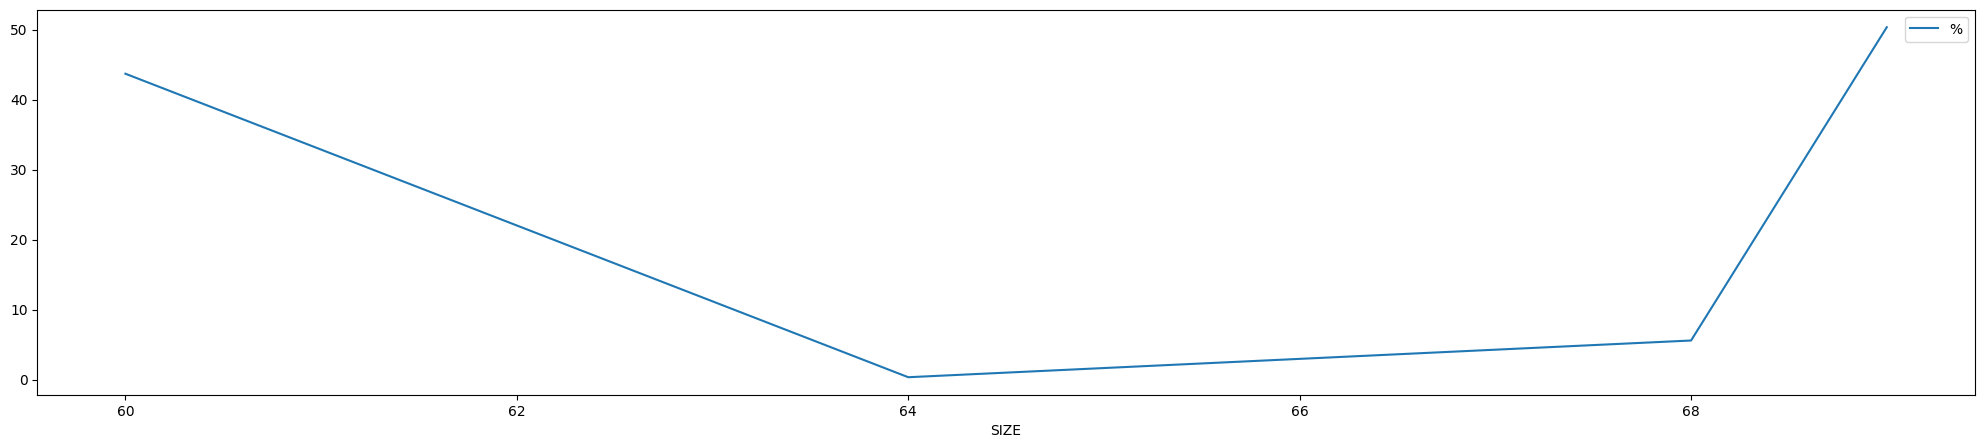

In [39]:
plt.figure(figsize=(25,5))

ax = pdf['%'].plot(label='%')
ax.legend(loc=1)

plt.show()

## 5 - Using the traffic generator to evaluate a game server

Here the notebook goes beyound the previous one. At this point, we have to start our custom-made game server to be able to communicate with the code running on this notebook. The code to the game client and game server will also be available on github. -TODO

#### Define usefull functions

In [40]:
# define the server address - this ip can be global if server is running outside main machine
HOST = 'localhost'
PORT = 26959
server_address = (HOST, PORT)

Here, we captured the initial packets the client communicates to the server while entering the game. This way, we can reproduce the same authentication in out simulated users.

In [41]:
def get_single_pcap_packet(pcap):
    """Extract data from the first packet in a pcap file"""
    for ts, buf in pcap:
        loo = dpkt.loopback.Loopback(buf)
        print(repr(loo), '\n')
        data = loo.data.data.data
        return data

In [42]:
# define path for welcomereceived packet
WelcomeReceived_path = os.path.join('.', 'client_packets', 'client_welcomereceived.pcap')

# get welcomereceived packet data
with open(WelcomeReceived_path, 'rb') as file:
    pcap = dpkt.pcap.Reader(file)
    client_welcomereceived = get_single_pcap_packet(pcap)

# display welcomereceived paccket from the capture

Loopback(family=2, data=IP(len=64, id=20727, df=1, ttl=128, p=6, src=b'\x7f\x00\x00\x01', dst=b'\x7f\x00\x00\x01', opts=b'', data=TCP(sport=61089, dport=26959, seq=2164798419, ack=820685656, flags=24, win=4058, sum=25756, opts=b'', data=b'\x14\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00\x08\x00\x00\x00USERNAME'))) 



Knowing that the packet used for authentication requires the client to return it's designated player number to the server, here we update the corresponding byte of information of the packet.

In [43]:
def update_welcome_client(data, client_id):
    """Update the client id of a welcomereceived packet"""
    data = bytearray(data)
    data[8] = client_id
    return bytes(data)

In [44]:
def update_udp_client(data, client_id):
    """Update the client id of a udp packet"""
    data = bytearray(data)
    data[0] = client_id
    return bytes(data)

Here we create a function for authenticating a bot to the game server, for practicallity

In [45]:
def connect_to_server(bots, i):
    """Connect the bot i to the game server"""
    bots[i]['tcp'].connect(server_address)
    bots[i]['tcp'].send(update_welcome_client(client_welcomereceived, i))

#### 5.1 - Using two threads per bot

On this strategy, we define the functions necessary for actually consuming the double buffer and sending it to our server. In this approach, each bot receives it's own generator of data, and its consumer threads.

In [46]:
def transmitter(queues, bot_id):
    """ I run on a thread, consuming a queue to transmit a packet in idt intervals """
    
    print("Transmitter started!")
    
    # keep transmitter running while generating_traffic
    while generating_traffic:
        
        # read queue is not empty
        if len(queues["read"]) != 0:
            
            # get packet info from queue
            packet = queues["read"].pop()
            
            # tranmit packet in idt time
            transmit_in_time(packet, bot_id)
        
        # read queue empty: swap queues
        else:
            swap_queues(queues)
            
    print("Transmitter shutting down!\n", end='')

In [47]:
def transmit_in_time(packet, bot_id):
    """ Wait for idt time in miliseconds to transmit a packet """
    # use global output dataframe
    global generated_traffic
    # use global packet counter
    global packet_counter
    
    # set target time
    t = datetime.datetime.now() + datetime.timedelta(milliseconds=packet['idt'])
    
    # wait for target time
    while t > datetime.datetime.now():
        continue
    
    # send packet 
    if packet['protocol'] == 'UDP':
        data = update_udp_client(packet['data'], bot_id)
        bots[bot_id]['udp'].sendto(data, server_address)
    elif packet['protocol'] == 'TCP':
        bots[bot_id]['tcp'].send(packet['data'])
    
    packet_counter += 1
    
    return

The following methos is used to create a bot, and assign it the necessary sockets, queues and threads.

In [48]:
def make_bot(bots, i):
    bots[i] = {}
    bots[i]['tcp'] = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    bots[i]['udp'] = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    bots[i]['queues'] = {"write": deque(maxlen=MAX_LEN), "read": deque(maxlen=MAX_LEN)}
    bots[i]['producer'] = threading.Thread(name='producer-' + str(i), target=generator, args=[bots[i]['queues']])
    bots[i]['consumer'] = threading.Thread(name='consumer-' + str(i), target=transmitter, args=[bots[i]['queues'], i])
    bots[i]['producer'].start()

In the following cell, we start generating traffic, and adding bots to the game, each time we press ENTER key

In [70]:
# start generating traffic
print('Start generating traffic')
generating_traffic = True

# initialize empty bots
bots = {}

# initialize bot index (1 is player):
bot_id = 2

# initialize packet counter
packet_counter = 0

# initialize packet counter timer
packet_counter_timer = datetime.datetime.now()

# loop asking for user to add new bot
while input("Add bot to game (enter):") == '':
    if packet_counter > 0:
        elapsed = datetime.datetime.now() - packet_counter_timer
        pps = packet_counter / (datetime.datetime.now() - packet_counter_timer).total_seconds()
        print(f"Packets-per-second with {bot_id - 2} bots: {pps}\n")
        
    packet_counter = 0
    packet_counter_timer = datetime.datetime.now()
    
    print(f'Starting bot id={bot_id}...')
    make_bot(bots, bot_id)
    connect_to_server(bots, bot_id)
    bots[bot_id]['consumer'].start()
    bot_id += 1
    print(f'Bot started!\n')

# stop generating traffic
print('-' * 50, '\nStop generating traffic')
generating_traffic = False

# stop all bots
print('Stopping all bots\n', end='')
for bot in bots.values():
    bot['tcp'].close()

Start generating traffic


Add bot to game (enter): 


Starting bot id=2...
Generator started!
Transmitter started!
Bot started!



Add bot to game (enter): 


Packets-per-second with 1 bots: 13.066437489272158

Starting bot id=3...
Generator started!
Transmitter started!
Bot started!



Add bot to game (enter): 


Packets-per-second with 2 bots: 23.226938805600117

Starting bot id=4...
Generator started!
Transmitter started!
Bot started!



Add bot to game (enter): 


Packets-per-second with 3 bots: 25.326485534054175

Starting bot id=5...
Generator started!
Transmitter started!Bot started!




Add bot to game (enter): 


Packets-per-second with 4 bots: 22.037549441454072

Starting bot id=6...
Generator started!
Transmitter started!
Bot started!



Add bot to game (enter): 


Packets-per-second with 5 bots: 23.900821381962768

Starting bot id=7...
Generator started!
Transmitter started!Bot started!




Add bot to game (enter): 


Packets-per-second with 6 bots: 24.160182553253524

Starting bot id=8...
Generator started!
Transmitter started!
Bot started!



Add bot to game (enter): 


Packets-per-second with 7 bots: 20.824125803198783

Starting bot id=9...
Generator started!
Transmitter started!
Bot started!



Add bot to game (enter): 


Packets-per-second with 8 bots: 24.61730989516142

Starting bot id=10...
Generator started!
Transmitter started!
Bot started!



Add bot to game (enter): 


Packets-per-second with 9 bots: 34.15177242820077

Starting bot id=11...
Generator started!
Transmitter started!
Bot started!



Add bot to game (enter): 


Packets-per-second with 10 bots: 25.11742395699897

Starting bot id=12...
Generator started!
Transmitter started!
Bot started!



Add bot to game (enter): 


Packets-per-second with 11 bots: 23.41013716270093

Starting bot id=13...
Generator started!
Transmitter started!Bot started!




Add bot to game (enter): 


Packets-per-second with 12 bots: 23.183234927745826

Starting bot id=14...
Generator started!
Transmitter started!
Bot started!



Add bot to game (enter): 


Packets-per-second with 13 bots: 28.03489055784886

Starting bot id=15...
Generator started!
Transmitter started!
Bot started!



Add bot to game (enter): 


Packets-per-second with 14 bots: 20.683520130188526

Starting bot id=16...
Generator started!
Transmitter started!
Bot started!



Exception in thread Exception in thread consumer-6:
Traceback (most recent call last):
  File "C:\Users\luc_b\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
consumer-12:
Traceback (most recent call last):
  File "C:\Users\luc_b\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\luc_b\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self.run()
  File "C:\Users\luc_b\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\luc_b\AppData\Local\Temp\ipykernel_3576\213111441.py", line 16, in transmitter
Exception in thread consumer-15:
Traceback (most recent call last):
  File "C:\Users\luc_b\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
        self.run()
  File "C:\Users\luc_b\AppData\Local\Programs\Python\Python310\lib\th

Add bot to game (enter): q


  File "C:\Users\luc_b\AppData\Local\Temp\ipykernel_3576\1292839882.py", line 20, in transmit_in_time
    self.run()
  File "C:\Users\luc_b\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
  File "C:\Users\luc_b\AppData\Local\Temp\ipykernel_3576\1292839882.py", line 20, in transmit_in_time
ConnectionAbortedErrorConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine
: [WinError 10053] An established connection was aborted by the software in your host machine
    self.run()
  File "C:\Users\luc_b\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\luc_b\AppData\Local\Temp\ipykernel_3576\213111441.py", line 16, in transmitter
  File "C:\Users\luc_b\AppData\Local\Temp\ipykernel_3576\1292839882.py", line 20, in transmit_in_time
Exception in thread consumer-10:
Traceback (most recent call last):
  File "C:\Users\luc_b\A

-------------------------------------------------- 
Stop generating traffic
Stopping all bots
Generator shutting down!
Generator shutting down!
Generator shutting down!
Generator shutting down!
Transmitter shutting down!
Transmitter shutting down!
Generator shutting down!
Generator shutting down!
Generator shutting down!
Transmitter shutting down!
Generator shutting down!
Generator shutting down!
Generator shutting down!
Generator shutting down!
Generator shutting down!
Generator shutting down!
Generator shutting down!
Transmitter shutting down!
Transmitter shutting down!
Transmitter shutting down!
Transmitter shutting down!
Transmitter shutting down!
Transmitter shutting down!
Generator shutting down!


ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine
ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine


The previous cell is the final one used for analysing the game server. Here we continuously added bots, mesuring the response time in the game client. The results are shown in the final report.

#### 5.2 - Using a single pair of producer and consumer threads 

This section is more of a test, and shouldn't really be considered as part of the project. Here it's an experiment to try not using two threads for each bot, here we would have only a producer and consumer thread, and every bot would use them,

In [232]:
def make_bot(bots, i):
    bots[i] = {}
    bots[i]['tcp'] = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    bots[i]['udp'] = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)

In [233]:
def transmitter(queues):
    """ I run on a thread, consuming a queue to transmit a packet in idt intervals """
    
    print("Transmitter started!")
    
    # keep transmitter running while generating_traffic
    while generating_traffic:
        
        # read queue is not empty
        if len(queues["read"]) != 0:
            
            # get packet info from queue
            packet = queues["read"].pop()
            
            # tranmit packet in idt time
            transmit_in_time(packet)
        
        # read queue empty: swap queues
        else:
            swap_queues(queues)
            
    print("Transmitter shutting down!\n", end='')

In [238]:
def transmit_in_time(packet):
    """ Wait for idt time in miliseconds to transmit a packet """
    # use global output dataframe
    global generated_traffic
    # use global packet counter
    global packet_counter
    # use global bots list
    global bots
    
    # set target time
    t = datetime.datetime.now() + datetime.timedelta(milliseconds=packet['idt'])
    
    # wait for target time
    while t > datetime.datetime.now():
        continue
    
    # send packet 
    if packet['protocol'] == 'UDP':
        for bot_id, bot in bots.items():
            data = update_udp_client(packet['data'], bot_id)
            bot['udp'].sendto(data, server_address)
            packet_counter += 1
    elif packet['protocol'] == 'TCP':
        for bot in bots.values():
            bot['tcp'].send(packet['data'])
            packet_counter += 1
    
    return

In [252]:
# initialize empty bots
bots = {}

# define two deques to work as producer and consumer buffers
queues = {"write": deque(maxlen=MAX_LEN), "read": deque(maxlen=MAX_LEN)}

# create threads for producer and consumer
p = threading.Thread(name='producer', target=generator, args=[queues])
c = threading.Thread(name='consumer', target=transmitter, args=[queues])

# start the generator
generating_traffic = True

# start the producer
p.start()

# initialize packet counter
packet_counter = 0

# number of bots
NUM_BOTS = 20

# create the bots
for i in range(2, NUM_BOTS + 2):
    make_bot(bots, i)
    connect_to_server(bots, i)
    time.sleep(0.2)

# wait a sec  for server to adapt to new bots
time.sleep(2)
    
# initialize packet counter timer
packet_counter_timer = datetime.datetime.now()

# start consumer
c.start()

Generator started!
Transmitter started!


In [248]:
elapsed = datetime.datetime.now() - packet_counter_timer
pps = packet_counter / (datetime.datetime.now() - packet_counter_timer).total_seconds()
print(f"Packets-per-second with {NUM_BOTS} bots: {pps}\n")

packet_counter = 0
packet_counter_timer = datetime.datetime.now()

Packets-per-second with 20 bots: 30.398791782578673



In [253]:
# stop generating packets
generating_traffic = False

# stop all bots
print('Stopping all bots\n', end='')
for bot in bots.values():
    bot['tcp'].close()

Stopping all bots
Generator shutting down!
Transmitter shutting down!


## 6 - Server analysis result

This section was done outside of the notebook.

In order to mesure the server performance, a timming function was added to the game client, where we mesure how long it takes for the human controlled character respond to a JUMP command. 10 time mesures were taken for each number of bot player togueter with the human, and a table was generated and processes using EXCEL. The results are displayed in the Final report of the project.